In [2]:
import pandas as pd
import numpy as np
from src import util
from src.transformation import transform
from src import config
from src import subject_manipulation
from typing import Tuple, List
from src.config import SUBJECT_DF_PATH, BLANK_ANSWER_LABEL, DELETION_ANSWER_LABEL, CANCELLED_LABEL, DIFFICULTIES, \
    MATH_SUBJECTS, COMPUTING_SUBJECTS, HUMAN_SUBJECTS, TECHNOLOGY_SUBJECTS
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches


In [ ]:
CODE_COURSE = None

In [3]:
years = [2017, 2014, 2011, 2008, 2005]

In [4]:
def read_csv_course(year, filter_by_course):
    df = transform.read_csv(year)
    if filter_by_course is not None:
        df = df.loc[df["CO_CURSO"] == CODE_COURSE]
    return df

In [5]:
subject_df = subject_manipulation.get_processed_subject_df(SUBJECT_DF_PATH)

In [6]:
def get_dict_all_years(filter_by_course: bool) -> dict:
        
    result = {}
    for year in years:
        result[year] = read_csv_course(year, filter_by_course=filter_by_course)
        
    return result

In [7]:
def get_display_df(year: int, input_df: pd.DataFrame,
                   subject_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    temp_subject_df = subject_df.loc[subject_df['ano'] == year].copy()
    
    util.map_presence(input_df)
    presence_df = input_df["TP_PRES"].value_counts()
    
    input_df = util.filter_present_students(input_df)
    subjects = util.get_subjects(temp_subject_df)
    input_df = util.add_all_score_categories(input_df, temp_subject_df, True, 
                                           subjects, util.get_subject_valid_questions)
    
    num_questions = []
    mean_acertos_by_subject = []
    std_acertos_by_subject = []
    column_zero_subject = []
    column_geq_one_subject = []
    column_all_subject = []
    num_alunos = input_df.shape[0]

    

    
    for subject in subjects:
        subject_questions = util.get_subject_valid_questions(subject, 
                                                                 temp_subject_df,
                                                                 input_df,
                                                                 just_objective=True)
        num_obj_subject_questions = len(subject_questions)
    
    
    
        mean_acertos_subject = input_df[f"ACERTOS_OBJ_{subject}"].mean()
    
        std_acertos_subject = input_df[f"ACERTOS_OBJ_{subject}"].std()
    
        zero_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"]).count(0) * 100 / num_alunos
    
        geq_one_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"] >= 1).count(True) * 100 / num_alunos
        
        all_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"] == num_obj_subject_questions).count(True) * 100 / num_alunos
        
        if num_obj_subject_questions > 0:
            num_questions.append(num_obj_subject_questions)
            mean_acertos_by_subject.append(mean_acertos_subject)
            std_acertos_by_subject.append(std_acertos_subject)
            column_zero_subject.append(zero_subject_percentage)
            column_geq_one_subject.append(geq_one_subject_percentage)
            column_all_subject.append(all_subject_percentage)
        else:
            num_questions.append(0)
            mean_acertos_by_subject.append(None)
            std_acertos_by_subject.append(None)
            column_zero_subject.append(None)
            column_geq_one_subject.append(None)
            column_all_subject.append(None)

    subjects_labels = [f"SCORE_OBJ_{x}" for x in subjects]

    mean_by_subject = input_df[subjects_labels].mean().values

    data = np.array([mean_by_subject, num_questions]).T

    display_df = pd.DataFrame(data=data, index=subjects, 
                          columns=["Nota %", "Nº Questões"])
    display_df["Nº Questões"] = display_df["Nº Questões"].astype(int, errors="ignore")
    display_df["Média Acertos"] = mean_acertos_by_subject
    display_df["Desvio Padrão Acertos"] = std_acertos_by_subject
    display_df["% de Zeros"] = column_zero_subject

    display_df["% de Alunos que acertaram pelo menos uma questão"] = column_geq_one_subject
    display_df["% de Alunos que acertaram todas"] = column_all_subject


    display_df = display_df.sort_values(by=["Nota %"]).round(2)

    
    return display_df, input_df, presence_df
    
    

In [8]:
dfs = get_dict_all_years(filter_by_course=True)

In [9]:

display_dfs = {}
presence_dfs = {}
for year in dfs.keys():
    enade_df = dfs[year]
    display_df, df, presence_df = get_display_df(year, enade_df, subject_df)
    dfs[year] = df
    display_dfs[year] = display_df
    presence_dfs[year] = presence_df   
    

/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/pandas/core/indexing.py:

In [10]:
def display_all_years_nota(all_dfs: dict) -> pd.DataFrame:
    data = {"2005": all_dfs[2005]["Nota %"].copy(),
            "2008": all_dfs[2008]["Nota %"].copy(),
            "2011": all_dfs[2011]["Nota %"].copy(),
            "2014": all_dfs[2014]["Nota %"].copy(),
            "2017": all_dfs[2017]["Nota %"].copy()}
    return pd.DataFrame(data)

Ano de 2017


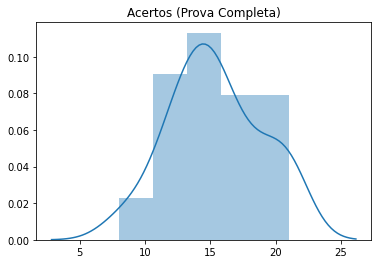

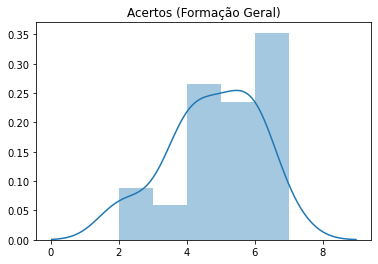

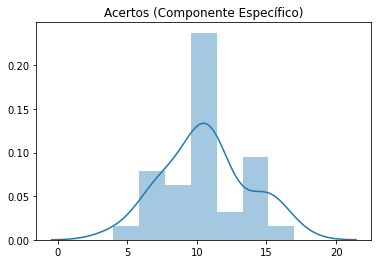

,Média Acertos,Desvio Padrão Acertos,Mediana Acertos,Skewness Acertos,Kurtosis Acertos,Moda Acertos,Nota %,Nº Questões Válidas
Prova Completa,15.38,3.52,15.0,0.07,-0.56,15,48.07,32
Formação Geral,4.76,1.35,5.0,-0.49,-0.33,6,59.56,8
Componente Específico,10.62,3.04,11.0,0.15,-0.26,11,44.24,24


In [11]:

def get_general_stats_df(df: pd.DataFrame, subject_df: pd.DataFrame, year: int):
    
    subject_df_year = subject_df.loc[subject_df["ano"] == year]
    
    objective_argument = subject_df_year["tipoquestao"] == "Objetiva"
    

    def get_general_statistics(df: pd.DataFrame, questions: List[int]) -> List[float]:
        
        status_relevant_questions = df[[f"QUESTAO_{i}_SITUACAO_DA_QUESTAO" for i in questions]].copy()
        valid_questions = status_relevant_questions.loc[:, (status_relevant_questions.iloc[0] != 1)].columns
        valid_questions = [int(x[len("QUESTAO_"):-len("_SITUACAO_DA_QUESTAO")]) for x in valid_questions]
    
        relevant_columns = df[[f"QUESTAO_{i}_NOTA" for i in valid_questions]].copy()
        relevant_columns = relevant_columns.replace([BLANK_ANSWER_LABEL, DELETION_ANSWER_LABEL], 0)
        relevant_columns = relevant_columns.astype(int)
        relevant_columns = relevant_columns / 100
        data = relevant_columns.sum(axis=1)
        mean_acertos = data.mean()
        median_acertos = data.median()
        std_acertos = data.std()
        skew_acertos = data.skew()
        kurtosis_acertos = data.kurtosis()
        mode_acertos = data.mode().astype(int)
        mode_acertos = mode_acertos.astype(str)
        mode_acertos = ", ".join(mode_acertos.tolist())

        return [mean_acertos, std_acertos, median_acertos, skew_acertos, kurtosis_acertos,
                            len(valid_questions)], mode_acertos, data

    modes = []
    index = ["Prova Completa", "Formação Geral", "Componente Específico"]
    columns = ["Média Acertos", "Desvio Padrão Acertos", "Mediana Acertos", 
                              "Skewness Acertos", "Kurtosis Acertos", "Nº Questões Válidas"]
    data = np.zeros((len(index), len(columns)), dtype=float)
    data_to_plot = []
    general_index = subject_df_year["prova"] == "Geral"
    specific_index = subject_df_year["prova"] == "Específica"
    questions_lists = [subject_manipulation.get_objective_questions(subject_df_year), # questões objetivas
                       subject_df_year.loc[objective_argument & general_index]["idquestao"].tolist(), #objetivas e de formação geral
                       subject_df_year.loc[objective_argument & specific_index]["idquestao"].tolist()] #objetivas de de formação especifica

    for type_exam_index, question_list in enumerate(questions_lists):
        data[type_exam_index], new_mode, new_data_to_plot = get_general_statistics(df, question_list)
        modes.append(new_mode)
        data_to_plot.append(new_data_to_plot)
    

    exam_df = pd.DataFrame(columns=columns, data=data, index=index)
    exam_df["Moda Acertos"] = modes
    exam_df["Nº Questões Válidas"] = exam_df["Nº Questões Válidas"].astype(int)
    exam_df["Nota %"] = exam_df["Média Acertos"] * 100 / exam_df["Nº Questões Válidas"]
    columns_without_num_questions = list(exam_df.columns)
    columns_without_num_questions.remove("Nº Questões Válidas")
    exam_df = exam_df[columns_without_num_questions + ["Nº Questões Válidas"]]

    return exam_df.round(2), data_to_plot

general_stats_dfs = {}
data_to_plot = {}

for year in dfs.keys():
    df = dfs[year].copy()
    general_stats_df, new_data_to_plot = get_general_stats_df(df, subject_df, year)
    general_stats_dfs[year] = general_stats_df
    data_to_plot[year] = new_data_to_plot

def plot_histogram(data_to_plot_year):
    labels = ["Prova Completa", "Formação Geral", "Componente Específico"]
    for data, label in zip(data_to_plot_year, labels):
        sns.distplot(data)
        plt.title(f"Acertos ({label})")
        plt.show()
    
year = 2017
print(f"Ano de {year}")
plot_histogram(data_to_plot[year])
general_stats_dfs[year]




Ano de 2014


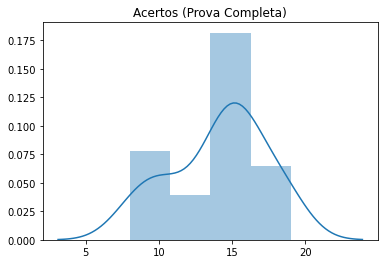

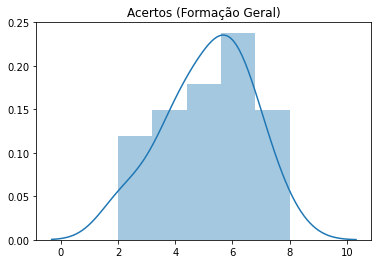

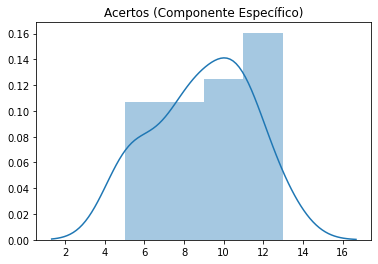

,Média Acertos,Desvio Padrão Acertos,Mediana Acertos,Skewness Acertos,Kurtosis Acertos,Moda Acertos,Nota %,Nº Questões Válidas
Prova Completa,14.07,3.23,15.0,-0.42,-0.70,"15, 16",48.52,29
Formação Geral,5.14,1.53,5.0,-0.39,-0.31,6,64.29,8
Componente Específico,8.93,2.43,9.0,-0.23,-0.89,11,42.52,21


In [12]:
year = 2014
print(f"Ano de {year}")
plot_histogram(data_to_plot[year])
general_stats_dfs[year]

Ano de 2011


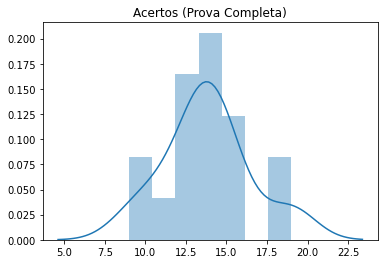

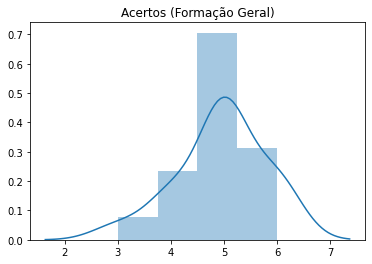

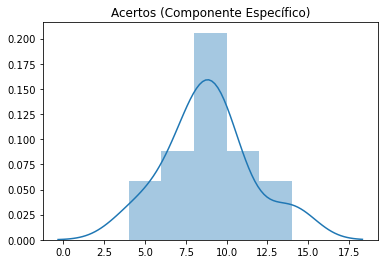

,Média Acertos,Desvio Padrão Acertos,Mediana Acertos,Skewness Acertos,Kurtosis Acertos,Moda Acertos,Nota %,Nº Questões Válidas
Prova Completa,13.82,2.65,14.0,0.35,0.57,14,47.67,29
Formação Geral,4.94,0.83,5.0,-0.63,0.55,5,61.76,8
Componente Específico,8.88,2.62,9.0,0.33,0.66,9,42.30,21


In [13]:
year = 2011
print(f"Ano de {year}")
plot_histogram(data_to_plot[year])
general_stats_dfs[year]

Ano de 2008


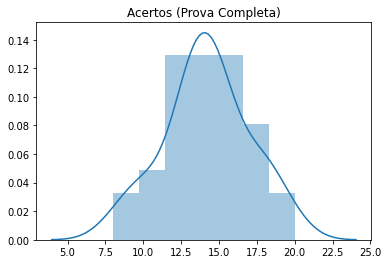

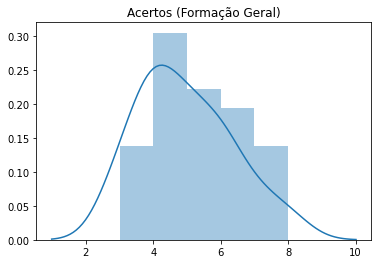

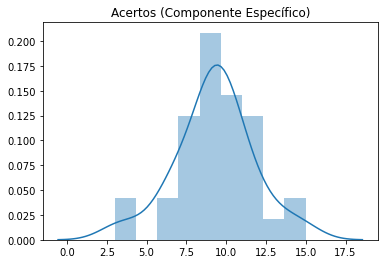

,Média Acertos,Desvio Padrão Acertos,Mediana Acertos,Skewness Acertos,Kurtosis Acertos,Moda Acertos,Nota %,Nº Questões Válidas
Prova Completa,14.19,2.81,14.0,-0.10,-0.10,14,40.56,35
Formação Geral,4.94,1.39,5.0,0.51,-0.42,4,61.81,8
Componente Específico,9.25,2.47,9.0,-0.18,0.92,9,34.26,27


In [14]:
year = 2008
print(f"Ano de {year}")
plot_histogram(data_to_plot[year])
general_stats_dfs[year]

Ano de 2005


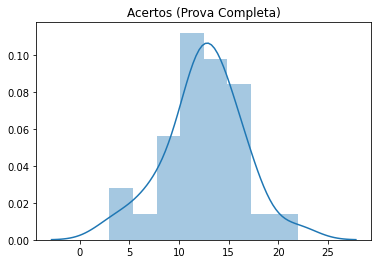

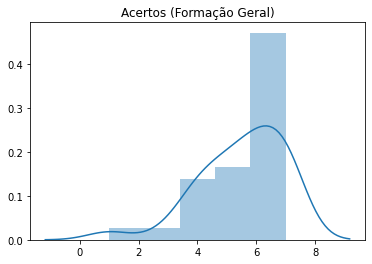

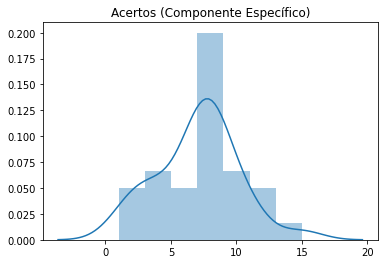

,Média Acertos,Desvio Padrão Acertos,Mediana Acertos,Skewness Acertos,Kurtosis Acertos,Moda Acertos,Nota %,Nº Questões Válidas
Prova Completa,12.53,3.91,12.5,-0.23,0.92,12,43.22,29
Formação Geral,5.50,1.46,6.0,-1.11,1.58,7,78.57,7
Componente Específico,7.03,3.09,7.5,0.07,0.46,8,31.97,22


In [15]:
year = 2005
print(f"Ano de {year}")
plot_histogram(data_to_plot[year])
general_stats_dfs[year]

In [16]:
all_years_score_df = display_all_years_nota(general_stats_dfs)
all_years_score_df

,2005,2008,2011,2014,2017
Prova Completa,43.22,40.56,47.67,48.52,48.07
Formação Geral,78.57,61.81,61.76,64.29,59.56
Componente Específico,31.97,34.26,42.30,42.52,44.24


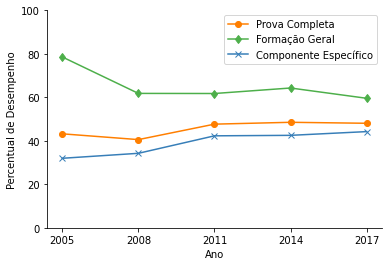

In [17]:
ax = plt.subplot(111)
plt.plot(all_years_score_df.loc["Prova Completa"],'o-', color="#ff7f00", label="Prova Completa")
plt.plot(all_years_score_df.loc["Formação Geral"],'d-', color="#4daf4a", label="Formação Geral")
plt.plot(all_years_score_df.loc["Componente Específico"],'x-', color="#377eb8", label="Componente Específico")
plt.legend()
plt.ylabel("Percentual de Desempenho")
plt.xlabel("Ano")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0,100)
plt.savefig("/tmp/type_exam_score", dpi=600)

In [18]:

def get_all_years_score(dfs: dict, subject_df: pd.DataFrame, years: List[int]):
  
    def auxiliar_function(df: pd.DataFrame, questions: List[int]) -> List[float]:
        
        status_relevant_questions = df[[f"QUESTAO_{i}_SITUACAO_DA_QUESTAO" for i in questions]].copy()
        valid_questions = status_relevant_questions.loc[:, (status_relevant_questions.iloc[0] != 1)].columns
        valid_questions = [int(x[len("QUESTAO_"):-len("_SITUACAO_DA_QUESTAO")]) for x in valid_questions]
        
        relevant_columns = df[[f"QUESTAO_{i}_NOTA" for i in valid_questions]].copy()
        relevant_columns = relevant_columns.replace([BLANK_ANSWER_LABEL, DELETION_ANSWER_LABEL], 0)
        relevant_columns = relevant_columns.astype(int)
        relevant_columns = relevant_columns / 100
        data = relevant_columns.sum(axis=1)
        correct_answered = data.sum()
        
        num_alunos = df.shape[0]
        answered = len(valid_questions) * num_alunos

        return [correct_answered, answered]


    all_year_general_score_dfs = []
    for year in years:
        df = dfs[year]
        
        subject_df_year = subject_df.loc[subject_df["ano"] == year]
    
        objective_argument = subject_df_year["tipoquestao"] == "Objetiva"
    
    
        index = ["Prova Completa", "Formação Geral", "Componente Específico"]
        columns = ["Numero Acertos", "Total de Questões Respondidas"]
        data = np.zeros((len(index), len(columns)), dtype=float)
        questions_lists = [subject_manipulation.get_objective_questions(subject_df_year),
                       subject_df_year.loc[objective_argument & (subject_df_year["prova"] == "Geral")]["idquestao"].tolist(),
                       subject_df_year.loc[objective_argument & (subject_df_year["prova"] == "Específica")]["idquestao"].tolist()]

        for type_exam_index, question_list in enumerate(questions_lists):
            data[type_exam_index] = auxiliar_function(df, question_list)
    
        year_general_score_df = pd.DataFrame(columns=columns, data=data, index=index)
        all_year_general_score_dfs.append(year_general_score_df)
        
    output_df = all_year_general_score_dfs[0]
    for df in all_year_general_score_dfs[1:]:
        output_df = output_df.add(df)
    
    output_df = output_df.astype(int)
    output_df["Nota %"] = output_df["Numero Acertos"] * 100 / output_df["Total de Questões Respondidas"]
    
    return output_df.round(2)
print("Dados de todos os anos considerando todos os alunos")
get_all_years_score(dfs, subject_df, dfs.keys())

Dados de todos os anos considerando todos os alunos


,Numero Acertos,Total de Questões Respondidas,Nota %
Prova Completa,2039,4523,45.08
Formação Geral,733,1130,64.87
Componente Específico,1306,3393,38.49
